`redwine-quality.ipynb`
# Red Wine Quality 🍇🍷

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

wine = pd.read_csv('./winequality-red.csv')

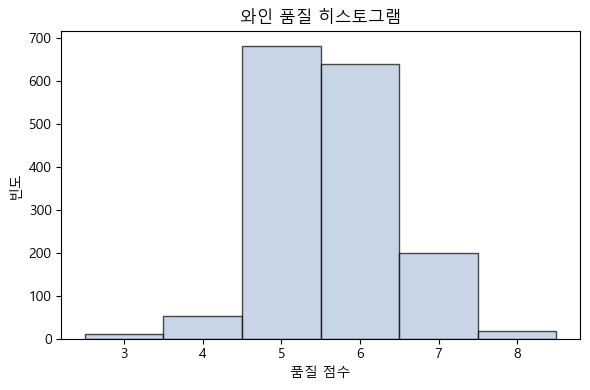

In [57]:
# 특성 살펴보기 (품질 분포, 히스토그램)
plt.figure(figsize=(6, 4))

plt.hist(wine['quality'], bins=np.arange(2.5, 9.5, 1), alpha=0.7, edgecolor='black', color='lightsteelblue')
plt.title('와인 품질 히스토그램')
plt.xlabel('품질 점수')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()

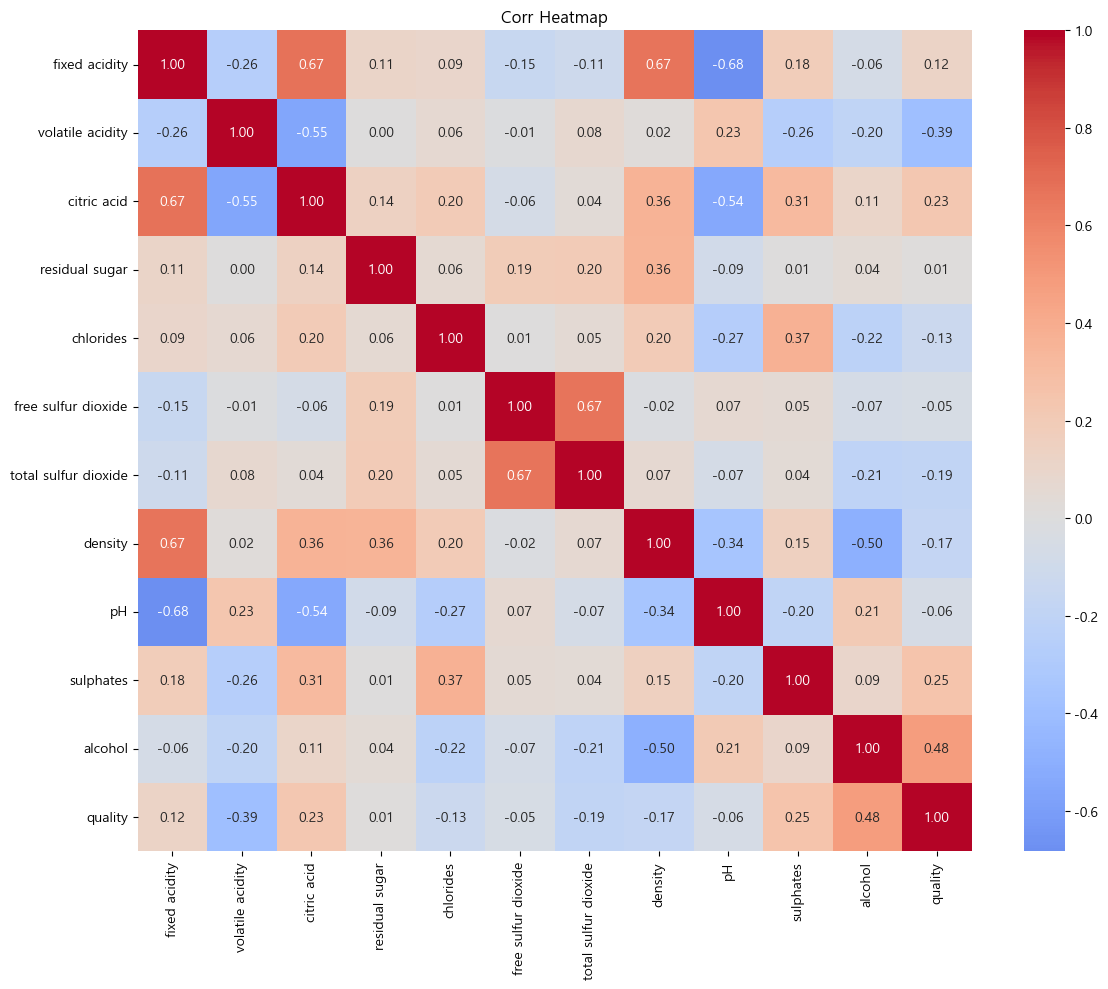

Highest Corr
alcohol: 0.476
volatile acidity: -0.391
sulphates: 0.251
citric acid: 0.226
total sulfur dioxide: -0.185
density: -0.175


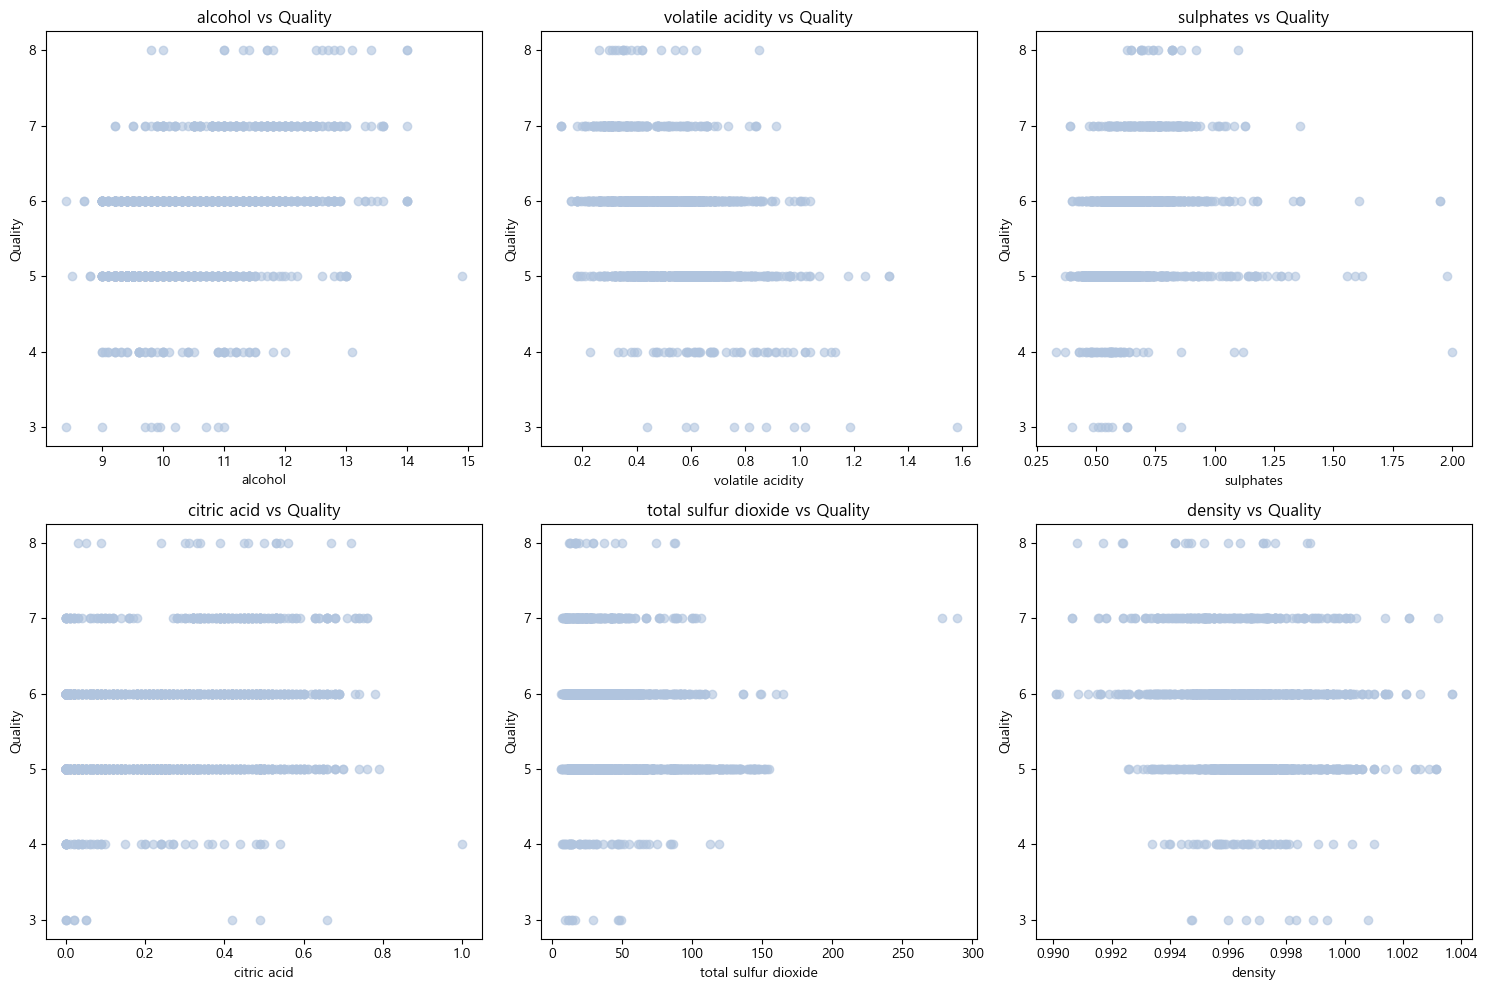

In [58]:
# 품질과의 상관관계 (히트맵) / 품질에 영향을 많이 주는 특성들 시각화
# 상관관계 히트맵
plt.figure(figsize=(12, 10))
correlation = wine.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Corr Heatmap')
plt.tight_layout()
plt.show()

# 품질과 가장 관련 높은 특성들
quality_corr = correlation['quality'].drop('quality').sort_values(key=abs, ascending=False)
print("Highest Corr")
for feature, corr in quality_corr.head(6).items():
    print(f"{feature}: {corr:.3f}")

# 품질에 영향을 많이 주는 특성들 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

top_features = quality_corr.head(6).index
for i, feature in enumerate(top_features):
    axes[i].scatter(wine[feature], wine['quality'], alpha=0.6, color='lightsteelblue')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Quality')
    axes[i].set_title(f'{feature} vs Quality')

plt.tight_layout()
plt.show()

In [59]:
from sklearn.model_selection import train_test_split
# 훈련 테스트 셋 나누기
y = wine['quality']
X = wine.drop(['quality'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(f'훈련 데이터: {len(X_train)}')
print(f'테스트 데이터: {len(X_test)}')

훈련 데이터: 1199
테스트 데이터: 400


In [60]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
# KNN 회귀로 와인 품질 예측 
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

k_scores = []

for k in range(1, 31):
    knr = KNeighborsRegressor(n_neighbors=k)
    knr.fit(X_train_scaled, y_train)
    knr_train_score = knr.score(X_train_scaled, y_train)
    knr_test_score = knr.score(X_test_scaled, y_test)
    k_scores.append((k, knr_test_score, knr_train_score))

max_k, max_test_score, max_train_score = max(k_scores, key=lambda x: x[1])
print(f'최고점수 k: {max_k}, 점수: {max_test_score:.4f}')

# best_knr = KNeighborsRegressor(n_neighbors=max_k)

최고점수 k: 14, 점수: 0.3504


In [61]:
from sklearn.linear_model import LinearRegression
# 선형회귀로 와인 품질 예측 (훈련셋/테스트셋의 점수를 높여보자)

lr_basic = LinearRegression()
lr_basic.fit(X_train, y_train)

lr_basic_score = lr_basic.score(X_test, y_test)

print(f'기본 LR Score(R^2): {lr_basic_score:.4f} (Train: {lr_basic.score(X_train, y_train)})')

# 예측 실제 값 계산(시각화)
lr_basic_pred = lr_basic.predict(X_test)

기본 LR Score(R^2): 0.3723 (Train: 0.354852874520566)


In [62]:
from sklearn.preprocessing import PolynomialFeatures
# 다항 회귀 (스케일링 필요)
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

poly_results = []
for degree in [2, 3, 4]:
    print(f'\n{degree}차수 다항식 특성 실험')
    # 다항식 특성 생성
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    print(f'원래 특성 수: {X_train_scaled.shape[1]}')
    print(f'다항식 특성 수: {X_train_poly.shape[1]}')

    # 모델 훈련
    lr_poly = LinearRegression()
    lr_poly.fit(X_train_poly, y_train)

    # 성능 평가
    poly_score = lr_poly.score(X_test_poly, y_test)
    poly_results.append((degree, poly_score))
    print(f'다항식 차수별 점수: {degree} -> {poly_score:.4f}')

    # Overfitting 체크를 위한 성능 확인
    train_score = lr_poly.score(X_train_poly, y_train)
    print(f'훈련 -> {train_score:.4f}')
    print(f'과적합정도 -> {train_score - poly_score:.4f}')


best_degree, best_score = max(poly_results, key=lambda x: x[1])
print(best_degree, best_score)

# 시각화를 위해 다시 훈련
poly_best = PolynomialFeatures(degree=best_degree)
X_train_poly_best = poly_best.fit_transform(X_train_scaled)
X_test_poly_best = poly_best.transform(X_test_scaled)

lr_poly_best = LinearRegression()
lr_poly_best.fit(X_train_poly_best, y_train)
lr_poly_best_score = lr_poly_best.score(X_test_poly_best, y_test)
lr_poly_best_pred = lr_poly_best.predict(X_test_poly_best)


2차수 다항식 특성 실험
원래 특성 수: 11
다항식 특성 수: 77
다항식 차수별 점수: 2 -> 0.3745
훈련 -> 0.4389
과적합정도 -> 0.0644

3차수 다항식 특성 실험
원래 특성 수: 11
다항식 특성 수: 363
다항식 차수별 점수: 3 -> -0.3482
훈련 -> 0.6528
과적합정도 -> 1.0010

4차수 다항식 특성 실험
원래 특성 수: 11
다항식 특성 수: 1364
다항식 차수별 점수: 4 -> -3185.0570
훈련 -> 1.0000
과적합정도 -> 3186.0570
2 0.37445416528963726


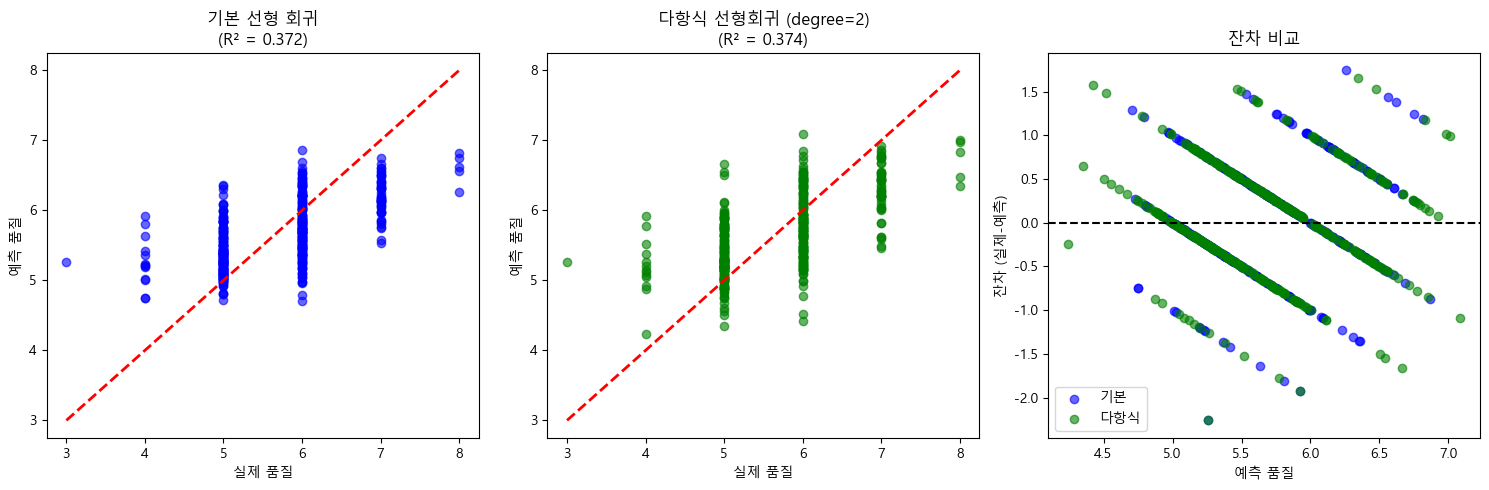

성능 향상: 0.0022 (0.6%)


In [63]:
# 예측 vs 실제값 비교
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, lr_basic_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('실제 품질')
plt.ylabel('예측 품질')
plt.title(f'기본 선형 회귀\n(R² = {lr_basic_score:.3f})')

plt.subplot(1, 3, 2)
plt.scatter(y_test, lr_poly_best_pred, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('실제 품질')
plt.ylabel('예측 품질')
plt.title(f'다항식 선형회귀 (degree={best_degree})\n(R² = {lr_poly_best_score:.3f})')

plt.subplot(1, 3, 3)
# 잔차 비교
residuals_basic = y_test - lr_basic_pred
residuals_poly = y_test - lr_poly_best_pred

plt.scatter(lr_basic_pred, residuals_basic, alpha=0.6, color='blue', label='기본')
plt.scatter(lr_poly_best_pred, residuals_poly, alpha=0.6, color='green', label='다항식')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('예측 품질')
plt.ylabel('잔차 (실제-예측)')
plt.title('잔차 비교')
plt.legend()

plt.tight_layout()
plt.show()

improvement = lr_poly_best_score - lr_basic_score
print(f"성능 향상: {improvement:.4f} ({improvement/lr_basic_score*100:.1f}%)")

In [64]:
from sklearn.linear_model import Ridge, Lasso

# 다항식 특성에 대해 Ridge/Lasso 적용 (앞서 만든 최적 degree 사용)
print(f"다항식 특성 (degree={best_degree}) 데이터 사용:")
print(f"특성 수: {X_train_poly_best.shape[1]}개")

# Ridge 회귀 (다항식 특성에 대해)
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
ridge_scores_poly = []
ridge_train_scores = []

print("\nRidge 회귀 (다항식 특성):")
for alpha in alphas:
    ridge_poly = Ridge(alpha=alpha)
    ridge_poly.fit(X_train_poly_best, y_train)
    
    # 테스트 성능
    ridge_score = ridge_poly.score(X_test_poly_best, y_test)
    ridge_scores_poly.append(ridge_score)
    
    # 훈련 성능 (과적합 체크용)
    ridge_train_score = ridge_poly.score(X_train_poly_best, y_train)
    ridge_train_scores.append(ridge_train_score)
    
    print(f"  alpha={alpha:7.3f}: 테스트={ridge_score:.4f}, 훈련={ridge_train_score:.4f}, 차이={ridge_train_score-ridge_score:.4f}")

best_ridge_alpha_poly = alphas[np.argmax(ridge_scores_poly)]
best_ridge_score_poly = max(ridge_scores_poly)

# Lasso 회귀 (다항식 특성에 대해)
lasso_scores_poly = []
lasso_train_scores = []

print("\nLasso 회귀 (다항식 특성):")
for alpha in alphas:
    lasso_poly = Lasso(alpha=alpha, max_iter=2000)
    lasso_poly.fit(X_train_poly_best, y_train)
    
    # 테스트 성능
    lasso_score = lasso_poly.score(X_test_poly_best, y_test)
    lasso_scores_poly.append(lasso_score)
    
    # 훈련 성능
    lasso_train_score = lasso_poly.score(X_train_poly_best, y_train)
    lasso_train_scores.append(lasso_train_score)
    
    print(f"  alpha={alpha:7.3f}: 테스트={lasso_score:.4f}, 훈련={lasso_train_score:.4f}, 차이={lasso_train_score-lasso_score:.4f}")

best_lasso_alpha_poly = alphas[np.argmax(lasso_scores_poly)]
best_lasso_score_poly = max(lasso_scores_poly)

print(f"\n🏆 최적 성능:")
print(f"Ridge (다항식) - alpha: {best_ridge_alpha_poly}, Score: {best_ridge_score_poly:.4f}")
print(f"Lasso (다항식) - alpha: {best_lasso_alpha_poly}, Score: {best_lasso_score_poly:.4f}")

다항식 특성 (degree=2) 데이터 사용:
특성 수: 78개

Ridge 회귀 (다항식 특성):
  alpha=  0.001: 테스트=0.3745, 훈련=0.4389, 차이=0.0644
  alpha=  0.010: 테스트=0.3745, 훈련=0.4389, 차이=0.0644
  alpha=  0.100: 테스트=0.3745, 훈련=0.4389, 차이=0.0643
  alpha=  1.000: 테스트=0.3753, 훈련=0.4388, 차이=0.0635
  alpha= 10.000: 테스트=0.3799, 훈련=0.4374, 차이=0.0575
  alpha=100.000: 테스트=0.3929, 훈련=0.4258, 차이=0.0329
  alpha=1000.000: 테스트=0.3496, 훈련=0.3498, 차이=0.0002

Lasso 회귀 (다항식 특성):
  alpha=  0.001: 테스트=0.3835, 훈련=0.4362, 차이=0.0527
  alpha=  0.010: 테스트=0.3904, 훈련=0.4104, 차이=0.0200
  alpha=  0.100: 테스트=0.3090, 훈련=0.3057, 차이=-0.0033
  alpha=  1.000: 테스트=-0.0020, 훈련=0.0000, 차이=0.0020
  alpha= 10.000: 테스트=-0.0020, 훈련=0.0000, 차이=0.0020
  alpha=100.000: 테스트=-0.0020, 훈련=0.0000, 차이=0.0020
  alpha=1000.000: 테스트=-0.0020, 훈련=0.0000, 차이=0.0020

🏆 최적 성능:
Ridge (다항식) - alpha: 100.0, Score: 0.3929
Lasso (다항식) - alpha: 0.01, Score: 0.3904


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

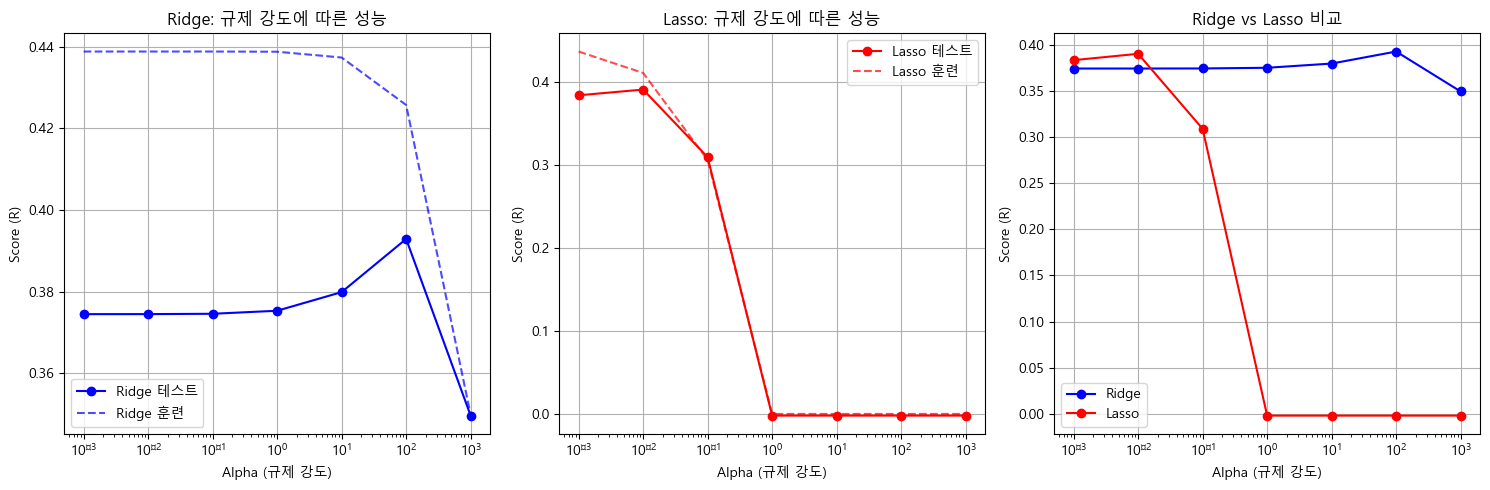

In [65]:
# Alpha 값에 따른 성능 비교 (훈련 vs 테스트)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(alphas, ridge_scores_poly, 'bo-', label='Ridge 테스트')
plt.plot(alphas, ridge_train_scores, 'b--', alpha=0.7, label='Ridge 훈련')
plt.xlabel('Alpha (규제 강도)')
plt.ylabel('Score (R)')
plt.title('Ridge: 규제 강도에 따른 성능')
plt.xscale('log')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(alphas, lasso_scores_poly, 'ro-', label='Lasso 테스트')
plt.plot(alphas, lasso_train_scores, 'r--', alpha=0.7, label='Lasso 훈련')
plt.xlabel('Alpha (규제 강도)')
plt.ylabel('Score (R)')
plt.title('Lasso: 규제 강도에 따른 성능')
plt.xscale('log')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(alphas, ridge_scores_poly, 'bo-', label='Ridge')
plt.plot(alphas, lasso_scores_poly, 'ro-', label='Lasso')
plt.xlabel('Alpha (규제 강도)')
plt.ylabel('Score (R)')
plt.title('Ridge vs Lasso 비교')
plt.xscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

💡 관찰:

Alpha가 작을 때: 훈련 성능 > 테스트 성능 (과적합)

Alpha가 클 때: 훈련과 테스트 성능이 비슷하지만 전체적으로 낮음 (과소적합)

적절한 Alpha: 과적합과 과소적합의 균형점

---

**데이터 준비 및 전처리**

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# 데이터 불러오기
wine = pd.read_csv('winequality-red.csv')

# 'quality'를 7점 이상이면 1, 아니면 0으로 변환
wine['good_quality'] = (wine['quality'] >= 7).astype(int)

# 원본 'quality' 컬럼 제거
wine = wine.drop('quality', axis=1)

# 독립 변수(X)와 종속 변수(y) 분리
X = wine.drop('good_quality', axis=1)
y = wine['good_quality']

# 전체 데이터(X)를 스케일링 (로지스틱 회귀용)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("데이터 전처리 및 스케일링 완료!")

데이터 전처리 및 스케일링 완료!


**로지스틱 회귀 교차 검증**

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

lr_model = LogisticRegression(random_state=42, max_iter=1000)

scores = cross_validate(lr_model, X_scaled, y, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)

print("--- 로지스틱 회귀 ---")
print(f"훈련 F1-점수 평균: {np.mean(scores['train_score']):.4f}")
print(f"테스트 F1-점수 평균: {np.mean(scores['test_score']):.4f}")

--- 로지스틱 회귀 ---
훈련 F1-점수 평균: 0.4399
테스트 F1-점수 평균: 0.3905


**결정 트리 교차 검증**

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

dt_model = DecisionTreeClassifier(random_state=42)

scores = cross_validate(dt_model, X, y, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)

print("--- 결정 트리 ---")
print(f"훈련 F1-점수 평균: {np.mean(scores['train_score']):.4f}")
print(f"테스트 F1-점수 평균: {np.mean(scores['test_score']):.4f}")

--- 결정 트리 ---
훈련 F1-점수 평균: 1.0000
테스트 F1-점수 평균: 0.3071


**랜덤 포레스트 교차 검증**

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

rf_model = RandomForestClassifier(random_state=42)

scores = cross_validate(rf_model, X, y, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)

print("--- 랜덤 포레스트 ---")
print(f"훈련 F1-점수 평균: {np.mean(scores['train_score']):.4f}")
print(f"테스트 F1-점수 평균: {np.mean(scores['test_score']):.4f}")

--- 랜덤 포레스트 ---
훈련 F1-점수 평균: 1.0000
테스트 F1-점수 평균: 0.3384


**LightGBM 교차 검증**

In [6]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate

lgbm_model = LGBMClassifier(random_state=42)

scores = cross_validate(lgbm_model, X, y, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)

print("--- LightGBM ---")
print(f"훈련 F1-점수 평균: {np.mean(scores['train_score']):.4f}")
print(f"테스트 F1-점수 평균: {np.mean(scores['test_score']):.4f}")

--- LightGBM ---
훈련 F1-점수 평균: 1.0000
테스트 F1-점수 평균: 0.4025


### 과적합 해결하기

**결정 트리 하이퍼파라미터 튜닝**

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# 튜닝할 파라미터 후보 정의
params = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_leaf': [1, 2, 4, 6]
}

# GridSearchCV 객체 생성 (F1-점수 기준)
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                           param_grid=params, 
                           cv=5, 
                           scoring='f1',
                           n_jobs=-1,
                           return_train_score=True)

# 튜닝 시작
grid_search.fit(X, y)

print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최고 테스트 F1-점수:", grid_search.best_score_.round(4))

# 튜닝된 모델의 훈련/테스트 점수 확인
best_dt_model = grid_search.best_estimator_
scores = cross_validate(best_dt_model, X, y, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)

print("\n--- 튜닝된 결정 트리 교차 검증 결과 ---")
print(f"훈련 F1-점수 평균: {np.mean(scores['train_score']):.4f}")
print(f"테스트 F1-점수 평균: {np.mean(scores['test_score']):.4f}")

최적의 하이퍼파라미터: {'max_depth': 3, 'min_samples_leaf': 2}
최고 테스트 F1-점수: 0.4146

--- 튜닝된 결정 트리 교차 검증 결과 ---
훈련 F1-점수 평균: 0.5021
테스트 F1-점수 평균: 0.4146


**랜덤 포레스트 하이퍼파라미터 튜닝**

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# 튜닝할 파라미터 후보 정의
params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [2, 4]
}

# GridSearchCV 객체 생성 (F1-점수 기준)
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), 
                           param_grid=params, 
                           cv=5, 
                           scoring='f1',
                           n_jobs=-1,
                           return_train_score=True)

# 튜닝 시작
grid_search.fit(X, y)

print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최고 테스트 F1-점수:", grid_search.best_score_.round(4))

# 튜닝된 모델의 훈련/테스트 점수 확인
best_rf_model = grid_search.best_estimator_
scores = cross_validate(best_rf_model, X, y, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)

print("\n--- 튜닝된 랜덤 포레스트 교차 검증 결과 ---")
print(f"훈련 F1-점수 평균: {np.mean(scores['train_score']):.4f}")
print(f"테스트 F1-점수 평균: {np.mean(scores['test_score']):.4f}")

최적의 하이퍼파라미터: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 200}
최고 테스트 F1-점수: 0.3747

--- 튜닝된 랜덤 포레스트 교차 검증 결과 ---
훈련 F1-점수 평균: 0.9618
테스트 F1-점수 평균: 0.3747


**LightGBM 하이퍼파라미터 튜닝**

In [9]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# 튜닝할 파라미터 후보 정의
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [10, 20]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(LGBMClassifier(random_state=42),
                           param_grid=params,
                           cv=5,
                           scoring='f1',
                           n_jobs=-1,
                           return_train_score=True)

# 튜닝 시작
grid_search.fit(X, y)

print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최고 테스트 F1-점수:", grid_search.best_score_.round(4))

# 튜닝된 모델의 훈련/테스트 점수 확인
best_lgbm_model = grid_search.best_estimator_
scores = cross_validate(best_lgbm_model, X, y, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)

print("\n--- 튜닝된 LightGBM 교차 검증 결과 ---")
print(f"훈련 F1-점수 평균: {np.mean(scores['train_score']):.4f}")
print(f"테스트 F1-점수 평균: {np.mean(scores['test_score']):.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 217, number of negative: 1382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number of data points in the train set: 1599, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135710 -> initscore=-1.851390
[LightGBM] [Info] Start training from score -1.851390
최적의 하이퍼파라미터: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 10}
최고 테스트 F1-점수: 0.4405

--- 튜닝된 LightGBM 교차 검증 결과 ---
훈련 F1-점수 평균: 1.0000
테스트 F1-점수 평균: 0.4405


## 분석 결과 요약
지금까지 진행했던 모든 모델의 최종 테스트 F1-점수를 한눈에 비교해 봅시다.

| 모델 | 튜닝 여부 | 테스트 F1-점수 |
| :--- | :--- | :--- |
| 로지스틱 회귀 | - | 0.3905 |
| 결정 트리 | 튜닝 전 | 0.3071 |
| 결정 트리 | 튜닝 후 | 0.4146 |
| 랜덤 포레스트 | 튜닝 전 | 0.3384 |
| 랜덤 포레스트 | 튜닝 후 | 0.3747 |
| LightGBM | 튜닝 전 | 0.4025 |
| LightGBM | 튜닝 후 | 0.4405 |


**최종 결과 해석**
- 가장 좋은 모델은 LightGBM: 튜닝된 LightGBM 모델이 0.4405의 F1-점수로 가장 높은 성능을 보였습니다. 부스팅 모델의 강력함을 다시 한번 확인할 수 있습니다.

- 과적합 문제의 한계: LightGBM 역시 훈련 F1-점수가 1.0으로 여전히 과적합된 모습을 보입니다. 이는 데이터 불균형이 심한 이 데이터셋의 근본적인 한계 때문이며, 모델의 하이퍼파라미터만으로는 해결하기 어렵다는 것을 보여줍니다.

**특성 공학 적용**

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_validate
from lightgbm import LGBMClassifier

# 1. 데이터 불러오기 및 전처리
wine = pd.read_csv('winequality-red.csv')
wine['good_quality'] = (wine['quality'] >= 7).astype(int)
wine = wine.drop('quality', axis=1)

X = wine.drop('good_quality', axis=1)
y = wine['good_quality']

# 2. 특성 공학 (다항 특성 추가)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

print("다항 특성 추가 후 데이터 형태:", X_poly.shape)

다항 특성 추가 후 데이터 형태: (1599, 77)


**LightGBM 교차 검증 (특성 공학 적용)**

In [11]:
# LightGBM 최적 모델 정의 (이전 단계에서 찾은 최적의 파라미터 적용)
lgbm_model = LGBMClassifier(n_estimators=200, learning_rate=0.1, num_leaves=10, random_state=42)

# 특성 공학이 적용된 데이터로 교차 검증 수행
scores = cross_validate(lgbm_model, X_poly, y, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)

print("--- 특성 공학 적용 후 LightGBM 교차 검증 결과 ---")
print(f"훈련 F1-점수 평균: {np.mean(scores['train_score']):.4f}")
print(f"테스트 F1-점수 평균: {np.mean(scores['test_score']):.4f}")

--- 특성 공학 적용 후 LightGBM 교차 검증 결과 ---
훈련 F1-점수 평균: 1.0000
테스트 F1-점수 평균: 0.4209


**여전히 과적합된 상태.**

- 테스트 F1-점수가 이전(0.4405)보다 오히려 소폭 하락함 -> 특성 공학이 항상 좋은 결과를 가져오는 것은 X

- 왜 특성 공학이 도움이 되지 않았을까?
    -우리가 추가한 다항 특성(degree=2)은 기존 11개의 특성을 77개의 특성으로 늘렸음. 
    - 모델은 이제 훨씬 더 많은 정보를 갖게 되었지만, 이 정보 중에는 불필요하거나 노이즈가 되는 특성도 많음.
    - 데이터의 양은 그대로인데 특성의 수만 늘어나니, 모델이 더 쉽게 데이터를 외워버리게 되는 과적합이 심화된 것.
    - 이는 특성 공학이 때로는 독이 될 수도 있다는 것을 보여주는 중요한 사례가 될 수 있다.

- 지금까지의 분석을 통해 우리는 이 문제의 핵심 원인이 클래스 불균형임을 확실히 알게 되었음. 모델 튜닝이나 특성 공학으로는 이 근본적인 문제를 해결 X

**SMOTE 적용 후 LightGBM 교차 검증**

In [12]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from lightgbm import LGBMClassifier

# SMOTE와 모델을 결합한 파이프라인 생성
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LGBMClassifier(n_estimators=200, learning_rate=0.1, num_leaves=10, random_state=42))
])

# 파이프라인으로 교차 검증 수행
scores = cross_validate(pipeline, X, y, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)

print("--- SMOTE 적용 후 LightGBM 교차 검증 결과 ---")
print(f"훈련 F1-점수 평균: {np.mean(scores['train_score']):.4f}")
print(f"테스트 F1-점수 평균: {np.mean(scores['test_score']):.4f}")

--- SMOTE 적용 후 LightGBM 교차 검증 결과 ---
훈련 F1-점수 평균: 0.9943
테스트 F1-점수 평균: 0.4549


---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Kaggle 데이터 로드
wine_df = pd.read_csv('./winequality-red.csv')

print(f"총 와인 샘플: {len(wine_df)}개")
print(f"특성 개수: {len(wine_df.columns)-1}개")
print(f"품질 범위: {wine_df['quality'].min()}점 ~ {wine_df['quality'].max()}점")
print("\n📊 데이터 미리보기:")
wine_df.head()

총 와인 샘플: 1599개
특성 개수: 11개
품질 범위: 3점 ~ 8점

📊 데이터 미리보기:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


  fixed acidity       : 고정 산도 - 와인의 신맛과 보존성
  volatile acidity    : 휘발성 산도 - 식초 맛, 높으면 불쾌한 냄새
  citric acid         : 구연산 - 신선함과 과일 향
  residual sugar      : 잔당 - 단맛의 정도
  chlorides           : 염분 - 짠맛
  free sulfur dioxide : 자유 이산화황 - 산화 방지
  total sulfur dioxide: 총 이산화황 - 보존제
  density             : 밀도 - 당분과 알코올에 영향
  pH                  : 산성도 - 3-4가 이상적
  sulphates           : 황산염 - 항산화제, 품질 향상
  alcohol             : 알코올 도수 - 맛과 보디감


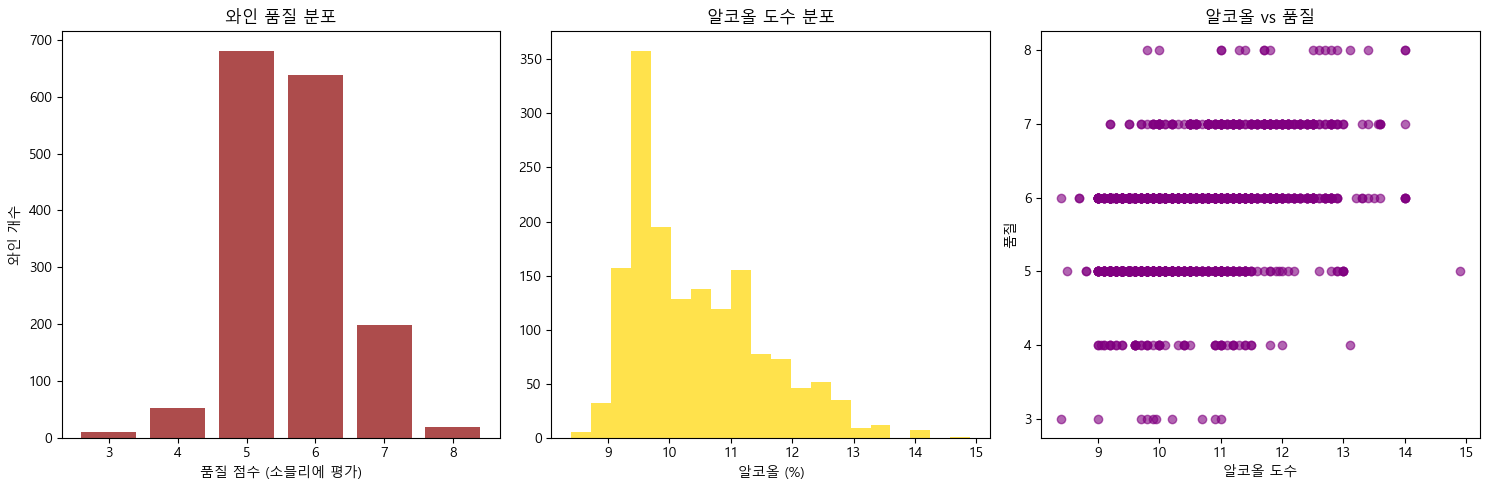


💡 발견:
  • 대부분 와인이 5-6점 (보통 품질)
  • 알코올 도수는 8-15% 범위
  • 고급 와인 (8-9점)은 희귀!


In [2]:
features_explanation = {
    'fixed acidity': '고정 산도 - 와인의 신맛과 보존성',
    'volatile acidity': '휘발성 산도 - 식초 맛, 높으면 불쾌한 냄새',
    'citric acid': '구연산 - 신선함과 과일 향',
    'residual sugar': '잔당 - 단맛의 정도',
    'chlorides': '염분 - 짠맛',
    'free sulfur dioxide': '자유 이산화황 - 산화 방지',
    'total sulfur dioxide': '총 이산화황 - 보존제',
    'density': '밀도 - 당분과 알코올에 영향',
    'pH': '산성도 - 3-4가 이상적',
    'sulphates': '황산염 - 항산화제, 품질 향상',
    'alcohol': '알코올 도수 - 맛과 보디감'
}

for feature, explanation in features_explanation.items():
    print(f"  {feature:20s}: {explanation}")

# 와인 품질 분포 - 소믈리에들의 평가!
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
quality_counts = wine_df['quality'].value_counts().sort_index()
plt.bar(quality_counts.index, quality_counts.values, color='darkred', alpha=0.7)
plt.title('와인 품질 분포')
plt.xlabel('품질 점수 (소믈리에 평가)')
plt.ylabel('와인 개수')

plt.subplot(1, 3, 2)
plt.hist(wine_df['alcohol'], bins=20, color='gold', alpha=0.7)
plt.title('알코올 도수 분포')
plt.xlabel('알코올 (%)')

plt.subplot(1, 3, 3)
plt.scatter(wine_df['alcohol'], wine_df['quality'], alpha=0.6, color='purple')
plt.title('알코올 vs 품질')
plt.xlabel('알코올 도수')
plt.ylabel('품질')

plt.tight_layout()
plt.show()

print(f"\n💡 발견:")
print(f"  • 대부분 와인이 5-6점 (보통 품질)")
print(f"  • 알코올 도수는 8-15% 범위")
print(f"  • 고급 와인 (8-9점)은 희귀!")

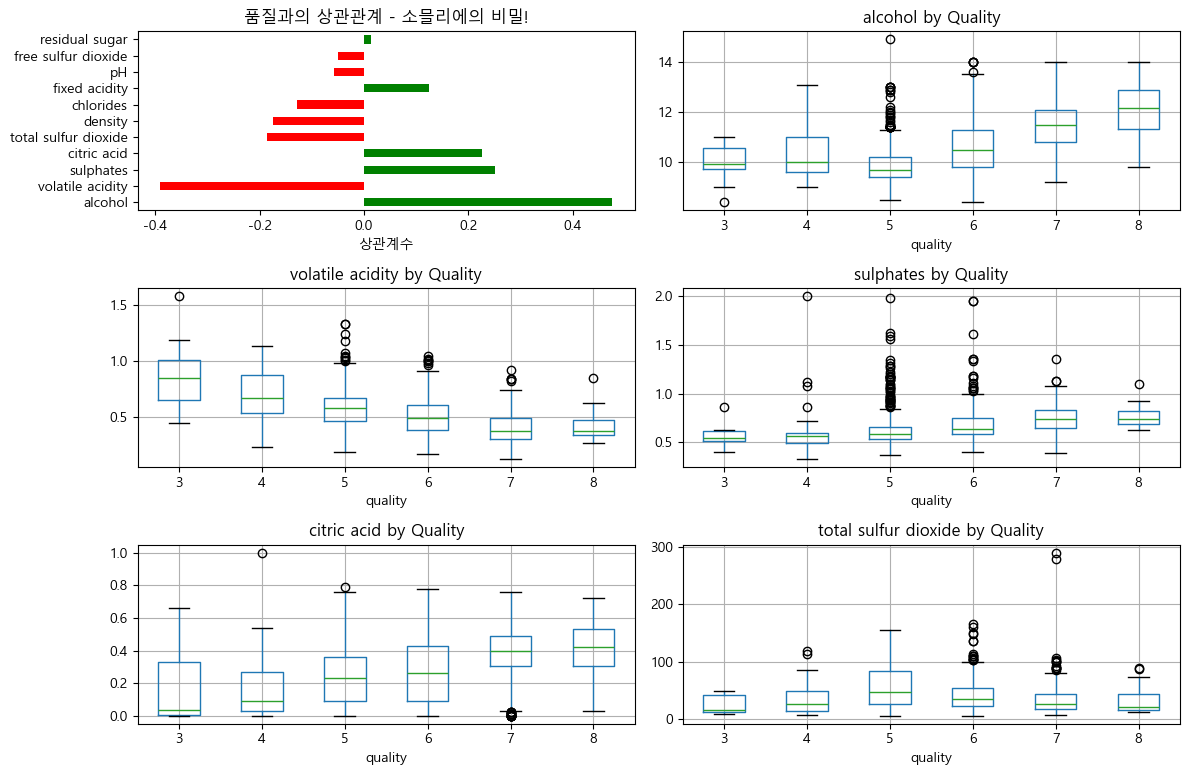

상관관계 순위:
 1. alcohol             :  0.476
 2. volatile acidity    : -0.391
 3. sulphates           :  0.251
 4. citric acid         :  0.226
 5. total sulfur dioxide: -0.185
 6. density             : -0.175
 7. chlorides           : -0.129
 8. fixed acidity       :  0.124
 9. pH                  : -0.058
10. free sulfur dioxide : -0.051
11. residual sugar      :  0.014


In [3]:
# 품질과 가장 관련 높은 특성들 찾기

correlations = wine_df.corr()['quality'].drop('quality').sort_values(key=abs, ascending=False)

plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
correlations.plot(kind='barh', color=['green' if x > 0 else 'red' for x in correlations])
plt.title('품질과의 상관관계 - 소믈리에의 비밀!')
plt.xlabel('상관계수')

# 상위 특성들의 품질별 분포
plt.subplot(3, 2, 2)
top_features = correlations.abs().head(5).index
for i, feature in enumerate(top_features):
    plt.subplot(3, 2, i+2)
    wine_df.boxplot(column=feature, by='quality', ax=plt.gca())
    plt.title(f'{feature} by Quality')
    plt.suptitle('')

plt.tight_layout()
plt.show()

print("상관관계 순위:")
for i, (feature, corr) in enumerate(correlations.items(), 1):
    print(f"{i:2d}. {feature:20s}: {corr:6.3f}")

In [4]:
print("🎯 미션 선택의 시간!")
print("\n옵션 1: 회귀 문제 - 정확한 품질 점수 예측")
print("  • 목표: 5.6점, 6.2점 같은 연속적 점수")
print("  • 평가: R² Score, RMSE")
print("  • 장점: 세밀한 예측 가능")

print("\n옵션 2: 분류 문제 - 품질 등급 분류")
print("  • 목표: 저품질(3-5점), 보통(6점), 고품질(7-9점)")
print("  • 평가: Accuracy, F1-Score") 
print("  • 장점: 비즈니스에서 더 실용적")

print("\n🚀 우리의 선택: 둘 다 해보자!")

# 분류를 위한 타겟 생성
def categorize_wine_quality(quality):
    if quality <= 5:
        return 0  # 저품질
    elif quality == 6:
        return 1  # 보통품질  
    else:
        return 2  # 고품질

wine_df['quality_category'] = wine_df['quality'].apply(categorize_wine_quality)
quality_labels = {0: '저품질 (3-5점)', 1: '보통품질 (6점)', 2: '고품질 (7-9점)'}

print("\n🏷️ 품질 카테고리 분포:")
category_counts = wine_df['quality_category'].value_counts().sort_index()
for cat, count in category_counts.items():
    print(f"  {quality_labels[cat]}: {count}개 ({count/len(wine_df)*100:.1f}%)")

# 데이터 준비
X = wine_df.drop(['quality', 'quality_category'], axis=1)
y_regression = wine_df['quality']  # 회귀용
y_classification = wine_df['quality_category']  # 분류용

print(f"\n✅ 데이터 준비 완료!")
print(f"특성 개수: {len(X.columns)}")
print(f"샘플 수: {len(X)}")

🎯 미션 선택의 시간!

옵션 1: 회귀 문제 - 정확한 품질 점수 예측
  • 목표: 5.6점, 6.2점 같은 연속적 점수
  • 평가: R² Score, RMSE
  • 장점: 세밀한 예측 가능

옵션 2: 분류 문제 - 품질 등급 분류
  • 목표: 저품질(3-5점), 보통(6점), 고품질(7-9점)
  • 평가: Accuracy, F1-Score
  • 장점: 비즈니스에서 더 실용적

🚀 우리의 선택: 둘 다 해보자!

🏷️ 품질 카테고리 분포:
  저품질 (3-5점): 744개 (46.5%)
  보통품질 (6점): 638개 (39.9%)
  고품질 (7-9점): 217개 (13.6%)

✅ 데이터 준비 완료!
특성 개수: 11
샘플 수: 1599


In [5]:
# 데이터 분할 (회귀)
X_train, X_val, y_reg_train, y_reg_val = train_test_split(
    X, y_regression, test_size=0.2, random_state=42)

# 분류용도 같은 방식으로 분할
_, _, y_cls_train, y_cls_val = train_test_split(
    X, y_classification, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"🔄 데이터 분할 완료!")
print(f"훈련: {len(X_train)} | 검증: {len(X_val)}")

🔄 데이터 분할 완료!
훈련: 1279 | 검증: 320


In [6]:
regression_results = {}

# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_reg_train)
lr_score = lr_model.score(X_val_scaled, y_reg_val)
lr_pred = lr_model.predict(X_val_scaled)
lr_rmse = np.sqrt(mean_squared_error(y_reg_val, lr_pred))
regression_results['Linear Regression'] = {'r2': lr_score, 'rmse': lr_rmse}

# 2. Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_reg_train)
ridge_score = ridge_model.score(X_val_scaled, y_reg_val)
ridge_pred = ridge_model.predict(X_val_scaled)
ridge_rmse = np.sqrt(mean_squared_error(y_reg_val, ridge_pred))
regression_results['Ridge'] = {'r2': ridge_score, 'rmse': ridge_rmse}

# 3. Lasso Regression  
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train_scaled, y_reg_train)
lasso_score = lasso_model.score(X_val_scaled, y_reg_val)
lasso_pred = lasso_model.predict(X_val_scaled)
lasso_rmse = np.sqrt(mean_squared_error(y_reg_val, lasso_pred))
regression_results['Lasso'] = {'r2': lasso_score, 'rmse': lasso_rmse}

# 4. Polynomial Features + Ridge
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)

poly_ridge = Ridge(alpha=10.0)  # 더 강한 규제
poly_ridge.fit(X_train_poly, y_reg_train)
poly_score = poly_ridge.score(X_val_poly, y_reg_val)
poly_pred = poly_ridge.predict(X_val_poly)
poly_rmse = np.sqrt(mean_squared_error(y_reg_val, poly_pred))
regression_results['Polynomial Ridge'] = {'r2': poly_score, 'rmse': poly_rmse}

for model, scores in regression_results.items():
    print(f"  {model:18s}: R²={scores['r2']:.4f}, RMSE={scores['rmse']:.4f}")

print(f"특성 수 변화: {X_train_scaled.shape[1]} → {X_train_poly.shape[1]} (다항식)")

  Linear Regression : R²=0.4032, RMSE=0.6245
  Ridge             : R²=0.4032, RMSE=0.6245
  Lasso             : R²=0.3986, RMSE=0.6269
  Polynomial Ridge  : R²=0.4299, RMSE=0.6104
특성 수 변화: 11 → 66 (다항식)


In [7]:
# KNN with Cross Validation
k_range = [3, 5, 7, 10, 15, 20]
knn_cv_scores = []

for k in k_range:
    knn_model = KNeighborsRegressor(n_neighbors=k)
    cv_scores = cross_val_score(knn_model, X_train_scaled, y_reg_train, cv=5, scoring='r2')
    knn_cv_scores.append(cv_scores.mean())
    print(f"  KNN (K={k:2d}): CV R² = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

best_k = k_range[np.argmax(knn_cv_scores)]
knn_best = KNeighborsRegressor(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_reg_train)
knn_score = knn_best.score(X_val_scaled, y_reg_val)
knn_pred = knn_best.predict(X_val_scaled)
knn_rmse = np.sqrt(mean_squared_error(y_reg_val, knn_pred))
regression_results[f'KNN (K={best_k})'] = {'r2': knn_score, 'rmse': knn_rmse}

print(f"\n🏆 최적 KNN: K={best_k}, R²={knn_score:.4f}, RMSE={knn_rmse:.4f}")

  KNN (K= 3): CV R² = 0.2008 (±0.0427)
  KNN (K= 5): CV R² = 0.2418 (±0.0478)
  KNN (K= 7): CV R² = 0.2591 (±0.0443)
  KNN (K=10): CV R² = 0.2745 (±0.0602)
  KNN (K=15): CV R² = 0.2918 (±0.0607)
  KNN (K=20): CV R² = 0.3003 (±0.0630)

🏆 최적 KNN: K=20, R²=0.3744, RMSE=0.6394


In [8]:
# Decision Tree
dt_model = DecisionTreeRegressor(max_depth=8, random_state=42)
dt_model.fit(X_train, y_reg_train)  # 스케일링 불필요
dt_score = dt_model.score(X_val, y_reg_val)
dt_pred = dt_model.predict(X_val)
dt_rmse = np.sqrt(mean_squared_error(y_reg_val, dt_pred))
regression_results['Decision Tree'] = {'r2': dt_score, 'rmse': dt_rmse}

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
rf_model.fit(X_train, y_reg_train)
rf_score = rf_model.score(X_val, y_reg_val)
rf_pred = rf_model.predict(X_val)
rf_rmse = np.sqrt(mean_squared_error(y_reg_val, rf_pred))
regression_results['Random Forest'] = {'r2': rf_score, 'rmse': rf_rmse}

# Extra Trees
et_model = ExtraTreesRegressor(n_estimators=100, max_depth=8, random_state=42)
et_model.fit(X_train, y_reg_train)
et_score = et_model.score(X_val, y_reg_val)
et_pred = et_model.predict(X_val)
et_rmse = np.sqrt(mean_squared_error(y_reg_val, et_pred))
regression_results['Extra Trees'] = {'r2': et_score, 'rmse': et_rmse}

# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=42)
gb_model.fit(X_train, y_reg_train)
gb_score = gb_model.score(X_val, y_reg_val)
gb_pred = gb_model.predict(X_val)
gb_rmse = np.sqrt(mean_squared_error(y_reg_val, gb_pred))
regression_results['Gradient Boosting'] = {'r2': gb_score, 'rmse': gb_rmse}

tree_models = ['Decision Tree', 'Random Forest', 'Extra Trees', 'Gradient Boosting']
for model in tree_models:
    scores = regression_results[model]
    print(f"  {model:18s}: R²={scores['r2']:.4f}, RMSE={scores['rmse']:.4f}")

  Decision Tree     : R²=0.1868, RMSE=0.7290
  Random Forest     : R²=0.4949, RMSE=0.5746
  Extra Trees       : R²=0.4824, RMSE=0.5816
  Gradient Boosting : R²=0.4700, RMSE=0.5885


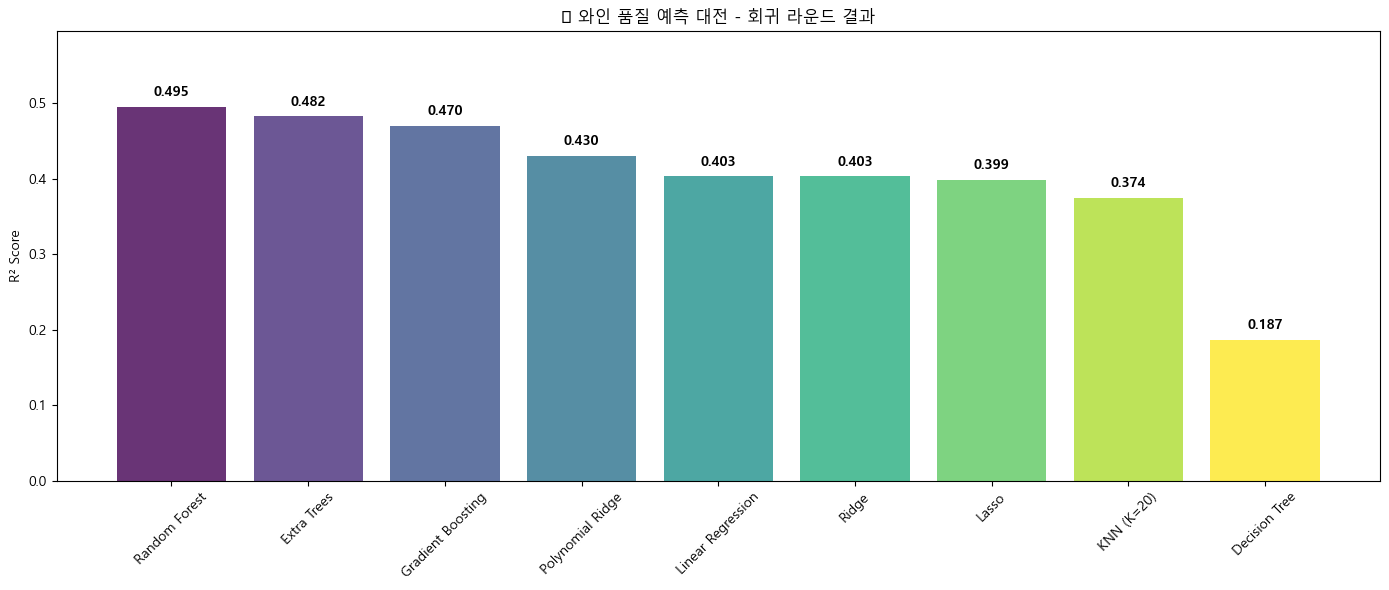


🥇 회귀 라운드 우승자: Random Forest
🏆 최고 성능: R² = 0.4949
🎯 해석: 품질 변동의 49.5%를 설명 가능!
✅ 괜찮은 성능! 경향성 파악에 유용


In [9]:
# 회귀 결과 정렬 및 시각화
regression_sorted = dict(sorted(regression_results.items(), 
                                key=lambda x: x[1]['r2'], reverse=True))

plt.figure(figsize=(14, 6))
models = list(regression_sorted.keys())
r2_scores = [regression_sorted[model]['r2'] for model in models]
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

bars = plt.bar(models, r2_scores, color=colors, alpha=0.8)
plt.title('🍷 와인 품질 예측 대전 - 회귀 라운드 결과')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.ylim(0, max(r2_scores) + 0.1)

for bar, score in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 승자 발표
regression_winner = models[0]
winner_score = r2_scores[0]
print(f"\n🥇 회귀 라운드 우승자: {regression_winner}")
print(f"🏆 최고 성능: R² = {winner_score:.4f}")
print(f"🎯 해석: 품질 변동의 {winner_score*100:.1f}%를 설명 가능!")

if winner_score > 0.6:
    print("✅ 훌륭한 성능! 실무에서 충분히 활용 가능")
elif winner_score > 0.4:
    print("✅ 괜찮은 성능! 경향성 파악에 유용")
else:
    print("🤔 아직 개선 여지가 있어요")

In [10]:
classification_results = {}

# KNN Classification
knn_cls = KNeighborsClassifier(n_neighbors=best_k)
knn_cls.fit(X_train_scaled, y_cls_train)
knn_cls_score = knn_cls.score(X_val_scaled, y_cls_val)
classification_results[f'KNN (K={best_k})'] = knn_cls_score

# Logistic Regression
lr_cls = LogisticRegression(random_state=42, max_iter=1000)
lr_cls.fit(X_train_scaled, y_cls_train)
lr_cls_score = lr_cls.score(X_val_scaled, y_cls_val)
classification_results['Logistic Regression'] = lr_cls_score

# Polynomial Logistic Regression
poly_lr_cls = LogisticRegression(random_state=42, max_iter=1000)
poly_lr_cls.fit(X_train_poly, y_cls_train)
poly_lr_score = poly_lr_cls.score(X_val_poly, y_cls_val)
classification_results['Polynomial Logistic'] = poly_lr_score

# Decision Tree Classification
dt_cls = DecisionTreeClassifier(max_depth=8, random_state=42)
dt_cls.fit(X_train, y_cls_train)
dt_cls_score = dt_cls.score(X_val, y_cls_val)
classification_results['Decision Tree'] = dt_cls_score

# Random Forest Classification
rf_cls = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
rf_cls.fit(X_train, y_cls_train)
rf_cls_score = rf_cls.score(X_val, y_cls_val)
classification_results['Random Forest'] = rf_cls_score

# Extra Trees Classification
et_cls = ExtraTreesClassifier(n_estimators=100, max_depth=8, random_state=42)
et_cls.fit(X_train, y_cls_train)
et_cls_score = et_cls.score(X_val, y_cls_val)
classification_results['Extra Trees'] = et_cls_score

# Gradient Boosting Classification
gb_cls = GradientBoostingClassifier(n_estimators=100, max_depth=6, random_state=42)
gb_cls.fit(X_train, y_cls_train)
gb_cls_score = gb_cls.score(X_val, y_cls_val)
classification_results['Gradient Boosting'] = gb_cls_score

print("📊 분류 라운드 결과:")
for model, score in classification_results.items():
    print(f"  {model:20s}: 정확도 = {score:.4f}")

📊 분류 라운드 결과:
  KNN (K=20)          : 정확도 = 0.5844
  Logistic Regression : 정확도 = 0.6250
  Polynomial Logistic : 정확도 = 0.6219
  Decision Tree       : 정확도 = 0.6250
  Random Forest       : 정확도 = 0.6562
  Extra Trees         : 정확도 = 0.6438
  Gradient Boosting   : 정확도 = 0.6687


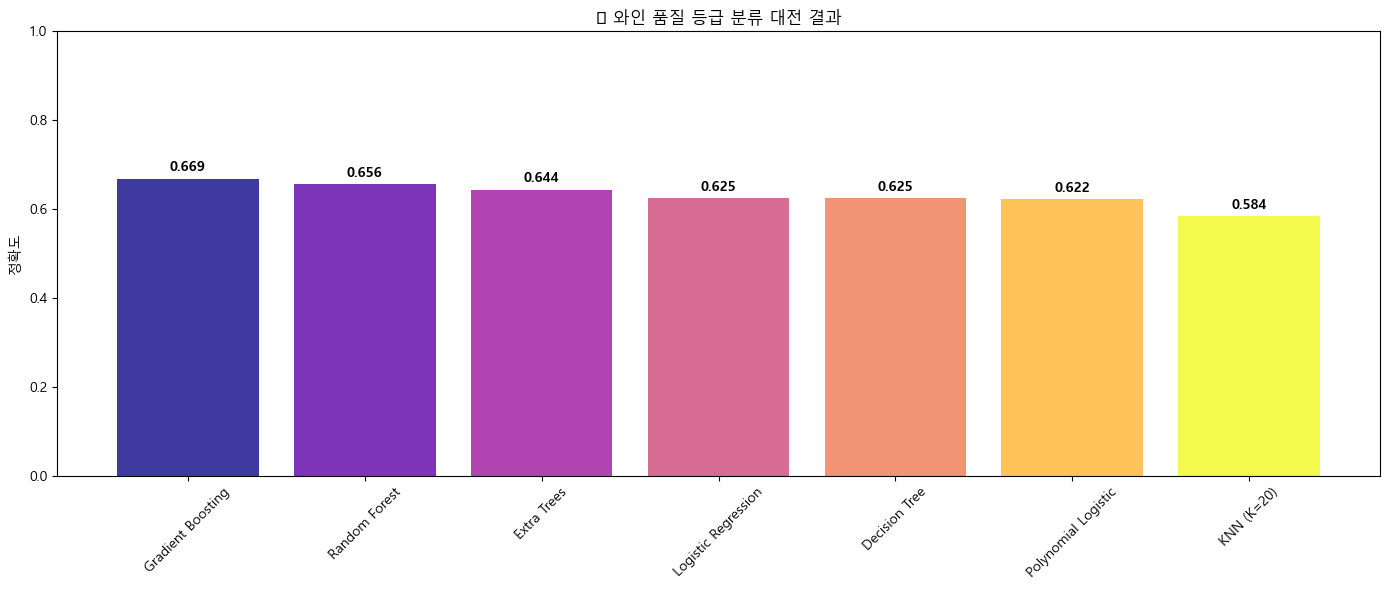


🥇 분류 라운드 우승자: Gradient Boosting
🏆 최고 정확도: 0.6687


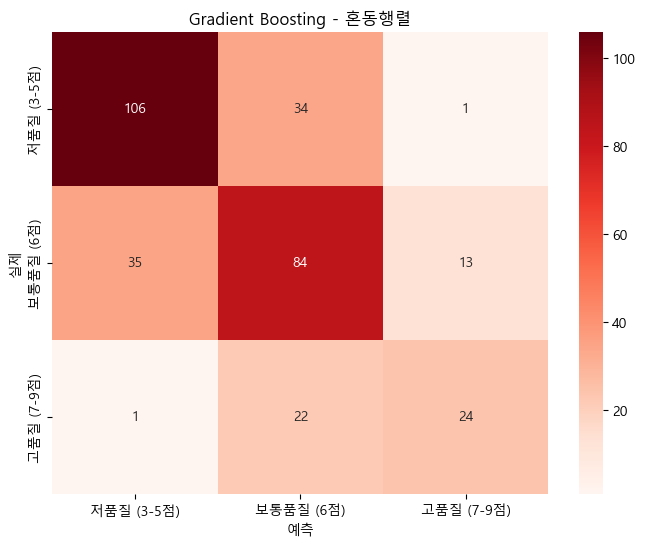


📊 등급별 예측 성능:
  저품질 (3-5점)     : 0.752 (106/141)
  보통품질 (6점)      : 0.636 (84/132)
  고품질 (7-9점)     : 0.511 (24/47)


In [11]:
# 분류 결과 시각화
classification_sorted = dict(sorted(classification_results.items(), 
                                   key=lambda x: x[1], reverse=True))

plt.figure(figsize=(14, 6))
models = list(classification_sorted.keys())
acc_scores = list(classification_sorted.values())
colors = plt.cm.plasma(np.linspace(0, 1, len(models)))

bars = plt.bar(models, acc_scores, color=colors, alpha=0.8)
plt.title('🍷 와인 품질 등급 분류 대전 결과')
plt.ylabel('정확도')
plt.xticks(rotation=45)
plt.ylim(0, 1)

for bar, score in zip(bars, acc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 분류 우승자 상세 분석
classification_winner = models[0]
winner_cls_score = acc_scores[0]

print(f"\n🥇 분류 라운드 우승자: {classification_winner}")
print(f"🏆 최고 정확도: {winner_cls_score:.4f}")

# 최고 모델의 혼동행렬
if 'Random Forest' in classification_winner:
    best_cls_model = rf_cls
elif 'Gradient Boosting' in classification_winner:
    best_cls_model = gb_cls
elif 'Extra Trees' in classification_winner:
    best_cls_model = et_cls
elif 'KNN' in classification_winner:
    best_cls_model = knn_cls
elif 'Logistic' in classification_winner:
    best_cls_model = lr_cls if 'Polynomial' not in classification_winner else poly_lr_cls
else:
    best_cls_model = dt_cls

# 예측 및 혼동행렬
if 'KNN' in classification_winner or 'Logistic' in classification_winner:
    if 'Polynomial' in classification_winner:
        y_cls_pred = best_cls_model.predict(X_val_poly)
    else:
        y_cls_pred = best_cls_model.predict(X_val_scaled)
else:
    y_cls_pred = best_cls_model.predict(X_val)

# 혼동행렬 시각화
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_cls_val, y_cls_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=[quality_labels[i] for i in range(3)],
            yticklabels=[quality_labels[i] for i in range(3)])
plt.title(f'{classification_winner} - 혼동행렬')
plt.xlabel('예측')
plt.ylabel('실제')
plt.show()

# 각 등급별 정확도
print("\n📊 등급별 예측 성능:")
for i in range(3):
    mask = (y_cls_val == i)
    if mask.sum() > 0:
        correct = (y_cls_pred[mask] == i).sum()
        total = mask.sum()
        accuracy = correct / total
        print(f"  {quality_labels[i]:15s}: {accuracy:.3f} ({correct}/{total})")

In [12]:
# 회귀와 분류 우승자 튜닝
regression_winner_model = regression_winner
classification_winner_model = classification_winner

print(f"🎯 회귀 우승자: {regression_winner_model}")
print(f"🎯 분류 우승자: {classification_winner_model}")

# Random Forest 튜닝 (일반적으로 우승 가능성 높음)
if 'Random Forest' in regression_winner_model:
    param_grid_reg = {
        'n_estimators': [50, 100, 200],
        'max_depth': [6, 8, 10, 12],
        'min_samples_split': [2, 5, 10]
    }
    
    grid_search_reg = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid_reg,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search_reg.fit(X_train, y_reg_train)
    
    print(f"✅ 최적 파라미터: {grid_search_reg.best_params_}")
    print(f"✅ 최적 CV 점수: {grid_search_reg.best_score_:.4f}")
    
    tuned_reg_score = grid_search_reg.score(X_val, y_reg_val)
    print(f"✅ 튜닝 후 검증 점수: {tuned_reg_score:.4f}")
    print(f"🚀 성능 향상: {tuned_reg_score - regression_results[regression_winner]['r2']:+.4f}")

# 분류도 같은 방식으로 튜닝
if 'Gradient Boosting' in classification_winner_model:
    param_grid_cls = {
        'n_estimators': [50, 100, 200],
        'max_depth': [6, 8, 10],
        'min_samples_split': [2, 5]
    }
    
    grid_search_cls = GridSearchCV(
        GradientBoostingClassifier(random_state=42),
        param_grid_cls,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search_cls.fit(X_train, y_cls_train)
    
    print(f"✅ 최적 파라미터: {grid_search_cls.best_params_}")
    print(f"✅ 최적 CV 점수: {grid_search_cls.best_score_:.4f}")
    
    tuned_cls_score = grid_search_cls.score(X_val, y_cls_val)
    print(f"✅ 튜닝 후 검증 점수: {tuned_cls_score:.4f}")
    print(f"🚀 성능 향상: {tuned_cls_score - classification_results[classification_winner]:+.4f}")

🎯 회귀 우승자: Random Forest
🎯 분류 우승자: Gradient Boosting
Fitting 5 folds for each of 36 candidates, totalling 180 fits
✅ 최적 파라미터: {'max_depth': 12, 'min_samples_split': 2, 'n_estimators': 200}
✅ 최적 CV 점수: 0.4242
✅ 튜닝 후 검증 점수: 0.5222
🚀 성능 향상: +0.0273
✅ 최적 파라미터: {'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 50}
✅ 최적 CV 점수: 0.7178
✅ 튜닝 후 검증 점수: 0.6750
🚀 성능 향상: +0.0063



🔬 와인과학자의 발견: 품질에 가장 중요한 요소들


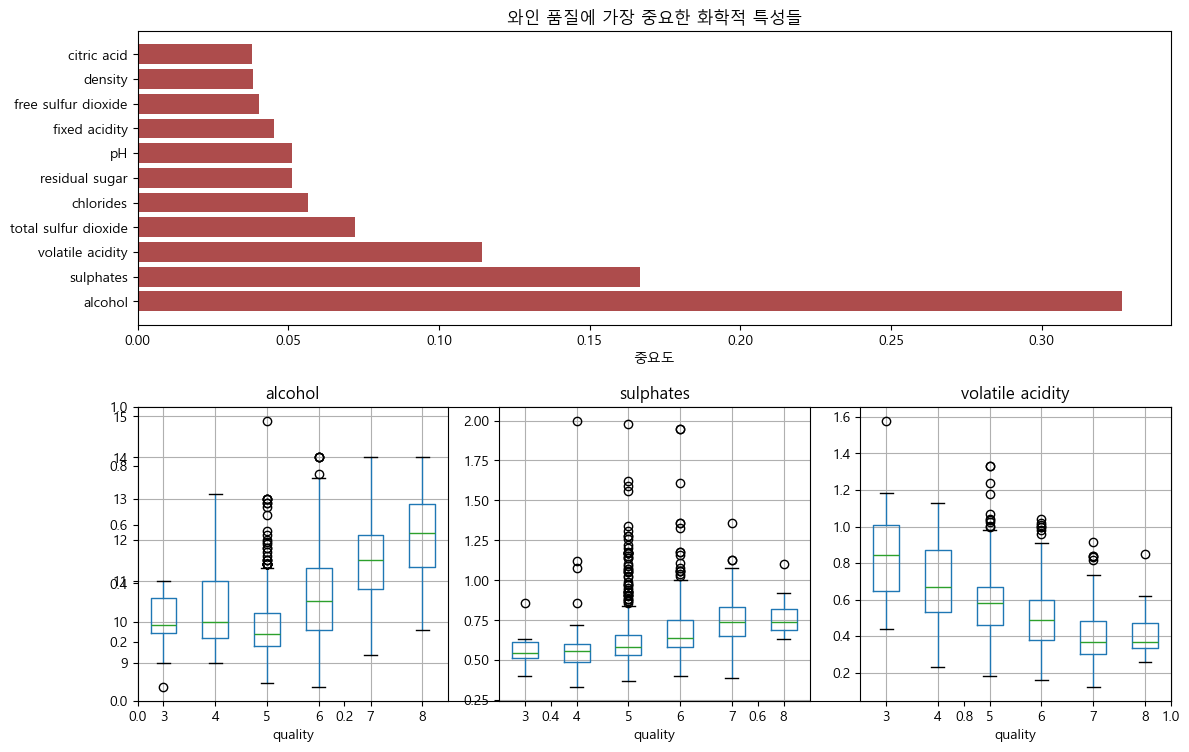

🏆 와인 품질에 가장 중요한 특성 TOP 5:


AttributeError: 'list' object has no attribute 'iterrows'

In [13]:
print("\n" + "="*60)
print("🔬 와인과학자의 발견: 품질에 가장 중요한 요소들")
print("="*60)

# 최고 모델의 특성 중요도 (트리 기반 모델인 경우)
if 'Random Forest' in regression_winner or 'Gradient Boosting' in regression_winner:
    if 'Random Forest' in regression_winner:
        model_for_importance = rf_model
    else:
        model_for_importance = gb_model
    
    importances = model_for_importance.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], 
             color='darkred', alpha=0.7)
    plt.title('와인 품질에 가장 중요한 화학적 특성들')
    plt.xlabel('중요도')
    
    # 상위 5개 특성의 품질별 분포
    top_5_features = feature_importance_df.head(5)['feature'].tolist()
    
    plt.subplot(2, 1, 2)
    for i, feature in enumerate(top_5_features[:3]):
        plt.subplot(2, 3, i+4)
        wine_df.boxplot(column=feature, by='quality', ax=plt.gca())
        plt.title(f'{feature}')
        plt.suptitle('')
    
    plt.tight_layout()
    plt.show()
    
    print("🏆 와인 품질에 가장 중요한 특성 TOP 5:")
    for i, row in top_5_features.iterrows():
        feature = row['feature']
        importance = row['importance']
        explanation = features_explanation.get(feature, "")
        print(f"  {i+1}. {feature:20s}: {importance:.3f} - {explanation}")

# 와인 추천 시스템 맛보기
print(f"\n🎯 AI 소믈리에의 와인 추천:")
print("완벽한 와인의 특성을 예측해보겠습니다!")

if 'Random Forest' in regression_winner:
    perfect_wine_features = X.mean()  # 평균적인 와인에서 시작
    
    # 중요한 특성들을 조정해서 품질 향상
    if 'alcohol' in top_5_features:
        perfect_wine_features['alcohol'] = wine_df['alcohol'].quantile(0.8)
    if 'sulphates' in top_5_features:
        perfect_wine_features['sulphates'] = wine_df['sulphates'].quantile(0.8)
    if 'volatile acidity' in top_5_features:
        perfect_wine_features['volatile acidity'] = wine_df['volatile acidity'].quantile(0.2)
    
    predicted_quality = rf_model.predict([perfect_wine_features])[0]
    print(f"AI가 설계한 완벽한 와인의 예상 품질: {predicted_quality:.2f}점")
    
    if predicted_quality >= 7:
        print("🍷 프리미엄급 와인이 탄생했습니다!")
    elif predicted_quality >= 6:
        print("🍷 좋은 품질의 와인입니다!")
    else:
        print("🍷 아직 개선의 여지가 있는 와인이네요.")